In [18]:
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt


In [19]:
np.random.seed(42)

def load_and_preprocess_data():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    X_train = X_train.reshape(-1, 28*28)
    X_test = X_test.reshape(-1, 28*28)
    y_train_binary = (y_train == 0).astype(int)
    y_test_binary = (y_test == 0).astype(int)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, y_train_binary, X_test, y_test_binary

In [20]:
def reduce_dimensionality(X_train, X_test, n_components=10):
    pca = PCA(n_components=n_components)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)
    print(f"PCA Explained Variance: {np.sum(pca.explained_variance_ratio_):.4f}")
    return X_train_reduced, X_test_reduced

In [21]:

# ANFIS Implementation
class ANFIS:
    def __init__(self, n_inputs, n_rules):
        self.n_inputs = n_inputs
        self.n_rules = n_rules
        self.params = self.initialize_parameters()

    def initialize_parameters(self):
        params = {
            'mf_params': np.zeros((self.n_rules, self.n_inputs, 2)),
            'consequent_params': np.random.randn(self.n_rules, 1) * 0.1
        }
        params['mf_params'][:, :, 0] = np.random.randn(self.n_rules, self.n_inputs) * 0.1
        params['mf_params'][:, :, 1] = np.abs(np.random.randn(self.n_rules, self.n_inputs)) + 0.5
        return params
    
    def gaussian_mf(self, x, params):
        center, sigma = params[:, :, 0], np.abs(params[:, :, 1]) + 1e-8
        memberships = np.exp(-((x[:, None, :] - center) ** 2) / (2 * sigma ** 2))
        memberships = np.clip(memberships, 1e-8, 1.0)
        return memberships
    
    def forward(self, X):
        memberships = self.gaussian_mf(X, self.params['mf_params'])
        firing_strengths = np.prod(memberships, axis=2)
        firing_sum = np.sum(firing_strengths, axis=1, keepdims=True)
        normalized_strengths = firing_strengths / (firing_sum + 1e-8)
        consequent = np.dot(normalized_strengths, self.params['consequent_params'])
        return consequent.squeeze()
    
    def train(self, X, y, X_val=None, y_val=None, epochs=100, lr=0.1):
        self.accuracy_history = []
        
        for epoch in range(epochs):
            # Forward pass
            output = self.forward(X)
            
            # Compute loss (MSE)
            loss = np.mean((output - y) ** 2)
            
            # Backpropagation (as you already have)
            grad_output = 2 * (output - y) / X.shape[0]
            memberships = self.gaussian_mf(X, self.params['mf_params'])
            firing_strengths = np.prod(memberships, axis=2)
            firing_sum = np.sum(firing_strengths, axis=1, keepdims=True)
            normalized_strengths = firing_strengths / (firing_sum + 1e-8)
            grad_consequent = np.dot(normalized_strengths.T, grad_output[:, None])
            self.params['consequent_params'] -= lr * grad_consequent
            
            error = output - y
            grad_mf_center = np.zeros_like(self.params['mf_params'][:, :, 0])
            grad_mf_sigma = np.zeros_like(self.params['mf_params'][:, :, 1])
            for r in range(self.n_rules):
                for i in range(self.n_inputs):
                    diff = X[:, i] - self.params['mf_params'][r, i, 0]
                    sigma = np.abs(self.params['mf_params'][r, i, 1]) + 1e-8
                    grad_mf_center[r, i] = np.mean(error * normalized_strengths[:, r] * diff / (sigma ** 2))
                    grad_mf_sigma[r, i] = np.mean(error * normalized_strengths[:, r] * (diff ** 2) / (sigma ** 3))
            self.params['mf_params'][:, :, 0] -= lr * grad_mf_center * 0.1
            self.params['mf_params'][:, :, 1] -= lr * grad_mf_sigma * 0.1
            
            # Compute accuracy on validation set (if provided)
            if X_val is not None and y_val is not None:
                y_pred_val = self.forward(X_val)
                acc = accuracy_score(y_val, np.round(y_pred_val))
                self.accuracy_history.append(acc)
                if epoch % 10 == 0:
                    print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")
    

PCA Explained Variance: 0.5511
Epoch 0, Loss: 0.0987, Accuracy: 0.9020
Epoch 10, Loss: 0.0987, Accuracy: 0.9020
Epoch 20, Loss: 0.0987, Accuracy: 0.9020
Epoch 30, Loss: 0.0987, Accuracy: 0.9020
Epoch 40, Loss: 0.0987, Accuracy: 0.9020
Epoch 50, Loss: 0.0987, Accuracy: 0.9020
Epoch 60, Loss: 0.0987, Accuracy: 0.9020
Epoch 70, Loss: 0.0987, Accuracy: 0.9020
Epoch 80, Loss: 0.0987, Accuracy: 0.9020
Epoch 90, Loss: 0.0987, Accuracy: 0.9020
Final Test Accuracy: 0.9020


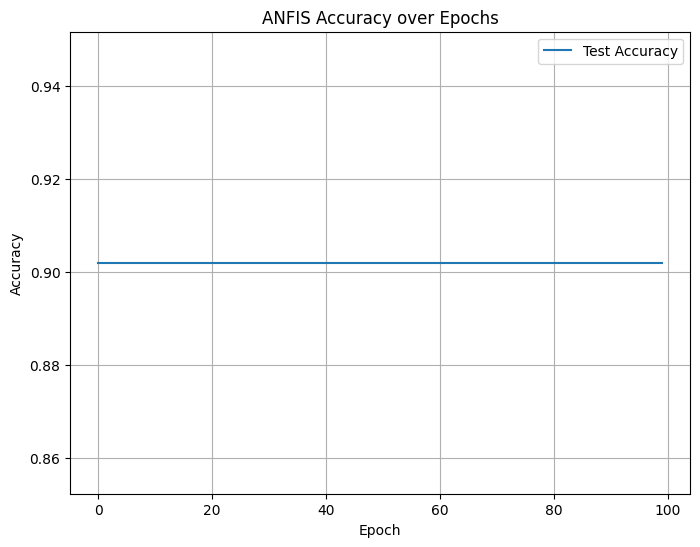

In [22]:
# Load and preprocess data
X_train, y_train, X_test, y_test = load_and_preprocess_data()
# Reduce dimensionality
X_train_reduced, X_test_reduced = reduce_dimensionality(X_train, X_test, n_components=50)
# Initialize and train ANFIS
anfis = ANFIS(n_inputs=50, n_rules=10)
anfis.train(X_train_reduced, y_train, X_test_reduced, y_test, epochs=100, lr=0.1)
# Final accuracy
y_pred = anfis.forward(X_test_reduced)
accuracy = accuracy_score(y_test, np.round(y_pred))
print(f"Final Test Accuracy: {accuracy:.4f}")
# Plot accuracy over epochs
plt.figure(figsize=(8, 6))
plt.plot(anfis.accuracy_history, label='Test Accuracy')
plt.title('ANFIS Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_graph.png')
plt.show()